In [4]:
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from dataset import PalindromeDataset
from lstm import LSTM
from train import train, evaluate 

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Running on device: {device}")

class ExperimentConfig:
    def __init__(self, input_length):
        self.input_length = input_length
        self.input_dim = 10   
        self.num_classes = 10
        self.num_hidden = 128
        self.batch_size = 128
        self.learning_rate = 0.001
        self.max_epoch = 100  # Early Stopping, Don't worry.
        self.max_norm = 10.0
        self.data_size = 10000
        self.portion_train = 0.8

def run_single_experiment(length):
    config = ExperimentConfig(input_length=length)
    
    dataset = PalindromeDataset(config.input_length, config.data_size, one_hot=True)
    
    train_size = int(len(dataset) * config.portion_train)
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    
    model = LSTM(
        seq_length=config.input_length,
        input_dim=config.input_dim,
        hidden_dim=config.num_hidden,
        output_dim=config.num_classes
    ).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(model.parameters(), lr=config.learning_rate)
    
    best_acc = 0.0

    # 针对短序列的特殊配置
    if length <= 5:
        current_batch_size = 16 
    else:
        current_batch_size = 128
        
    for epoch in range(config.max_epoch):
        train(model, train_loader, optimizer, criterion, device, config)
        _, val_acc = evaluate(model, val_loader, criterion, device, config)
        
        if val_acc > best_acc:
            best_acc = val_acc
            
        if val_acc >= 0.999:
            break
            
    return best_acc

Running on device: mps


In [5]:
lengths_to_test = [3, 7, 11, 13, 15, 17, 19, 21, 25]
runs_per_length = 3

lstm_means = []
lstm_stds = []

print(f"=== Starting LSTM Robustness Test ===")

for length in lengths_to_test:
    accs = []
    start_time = time.time()
    
    for i in range(runs_per_length):
        acc = run_single_experiment(length)
        accs.append(acc)
    
    mean_acc = np.mean(accs)
    std_acc = np.std(accs)
    lstm_means.append(mean_acc)
    lstm_stds.append(std_acc)
    
    print(f"Length {length:2d} | Avg Acc: {mean_acc:.4f} | Std: {std_acc:.4f} | Time: {time.time()-start_time:.1f}s")

print("Done.")

=== Starting LSTM Robustness Test ===
Setting total_len to the maximum possible length. 
[0/1] Loss: 2.304577 (2.304577) Accuracy: 0.075000 (0.075000)
[0/1] Loss: 2.350903 (2.350903) Accuracy: 0.000000 (0.000000)
[0/1] Loss: 2.254889 (2.254889) Accuracy: 0.225000 (0.225000)
[0/1] Loss: 2.368042 (2.368042) Accuracy: 0.100000 (0.100000)
[0/1] Loss: 2.210530 (2.210530) Accuracy: 0.300000 (0.300000)
[0/1] Loss: 2.376686 (2.376686) Accuracy: 0.100000 (0.100000)
[0/1] Loss: 2.153299 (2.153299) Accuracy: 0.337500 (0.337500)
[0/1] Loss: 2.374528 (2.374528) Accuracy: 0.150000 (0.150000)
[0/1] Loss: 2.076289 (2.076289) Accuracy: 0.375000 (0.375000)
[0/1] Loss: 2.360237 (2.360237) Accuracy: 0.150000 (0.150000)
[0/1] Loss: 1.973819 (1.973819) Accuracy: 0.437500 (0.437500)
[0/1] Loss: 2.330723 (2.330723) Accuracy: 0.150000 (0.150000)
[0/1] Loss: 1.842607 (1.842607) Accuracy: 0.475000 (0.475000)
[0/1] Loss: 2.281810 (2.281810) Accuracy: 0.150000 (0.150000)
[0/1] Loss: 1.684158 (1.684158) Accuracy: 0

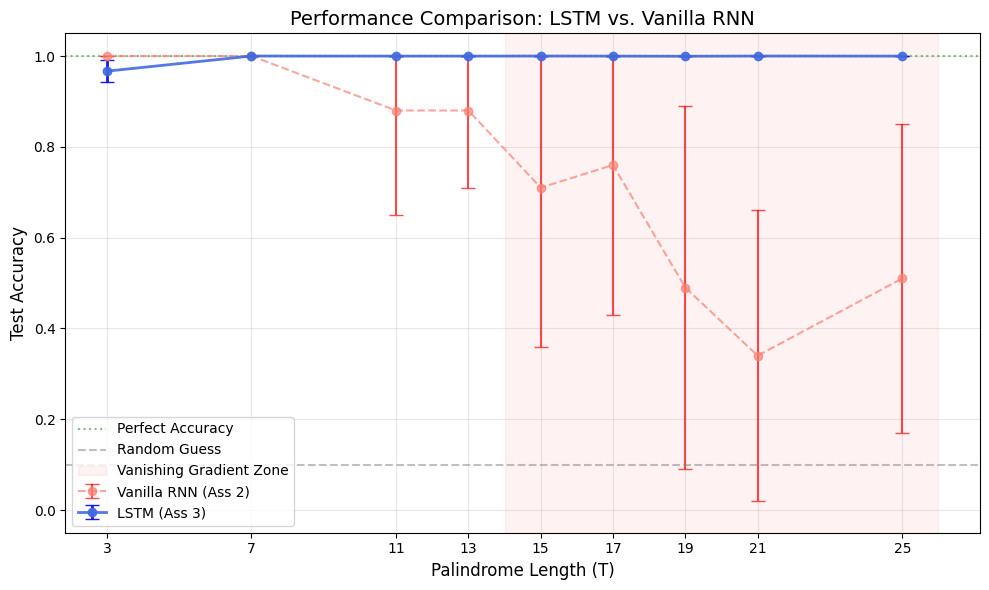

In [6]:
lstm_x = np.array(lengths_to_test)
lstm_y = np.array(lstm_means)
lstm_std = np.array(lstm_stds)


rnn_x = np.array([3, 7, 11, 13, 15, 17, 19, 21, 25])
rnn_y = np.array([1.0, 1.0, 0.88, 0.88, 0.71, 0.76, 0.49, 0.34, 0.51])
rnn_std = np.array([0.0, 0.0, 0.23, 0.17, 0.35, 0.33, 0.40, 0.32, 0.34])

lstm_lower = lstm_std
lstm_upper = np.minimum(lstm_std, 1.0 - lstm_y) # 确保加上误差后不超过 1.0
lstm_errors = [lstm_lower, lstm_upper]

rnn_lower = rnn_std
rnn_upper = np.minimum(rnn_std, 1.0 - rnn_y)
rnn_errors = [rnn_lower, rnn_upper]

plt.figure(figsize=(10, 6), dpi=100)

plt.errorbar(rnn_x, rnn_y, yerr=rnn_errors, 
             fmt='--o', capsize=5, color='salmon', ecolor='red', alpha=0.7,
             label='Vanilla RNN (Ass 2)')

plt.errorbar(lstm_x, lstm_y, yerr=lstm_errors, 
             fmt='-o', capsize=5, color='royalblue', ecolor='blue', alpha=0.9, linewidth=2,
             label='LSTM (Ass 3)')


plt.axhline(y=1.0, color='green', linestyle=':', alpha=0.5, label='Perfect Accuracy')
plt.axhline(y=0.1, color='gray', linestyle='--', alpha=0.5, label='Random Guess')
plt.axvspan(14, 26, color='red', alpha=0.05, label='Vanishing Gradient Zone')

plt.title('Performance Comparison: LSTM vs. Vanilla RNN', fontsize=14)
plt.xlabel('Palindrome Length (T)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.ylim(-0.05, 1.05) 
plt.xticks(sorted(list(set(list(rnn_x) + list(lstm_x)))))
plt.grid(True, alpha=0.3)
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()